In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import seaborn as sb

In [2]:
# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
y = np.log1p(train['SalePrice'])
test_ids = test['Id']
train.drop(['SalePrice', 'Id'], axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

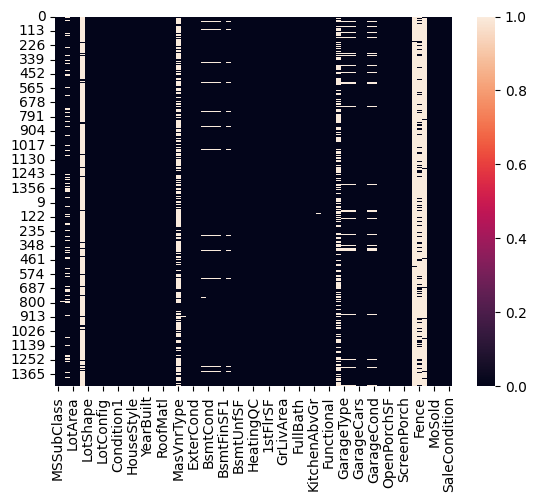

In [5]:
# Merge for feature engineering
all_data = pd.concat([train, test], axis=0)
#######Show empty data before#################
sb.heatmap(all_data.isnull())
# Fill NA for categorical with 'None', for numeric with 0
for col in all_data.columns:
    if all_data[col].dtype == "object":
        all_data[col] = all_data[col].fillna("None")
    else:
        all_data[col] = all_data[col].fillna(0)

#all_data.to_csv('new.csv', index=False,encoding='utf-8')

<Axes: >

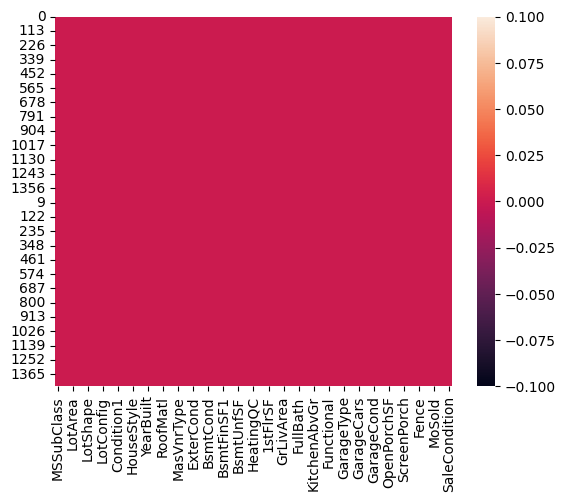

In [8]:
#######Show empty data after#################
#sb.heatmap(all_data.isnull())
# Encode categorical features
for col in all_data.select_dtypes('object').columns:
    all_data[col] = LabelEncoder().fit_transform(all_data[col])

sb.heatmap(all_data.isnull())    


In [ ]:
# Feature engineering
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['TotalBath'] = all_data['FullBath'] + 0.5 * all_data['HalfBath'] + all_data['BsmtFullBath'] + 0.5 * all_data['BsmtHalfBath']
all_data['Age'] = all_data['YrSold'] - all_data['YearBuilt']
all_data['RemodAge'] = all_data['YrSold'] - all_data['YearRemodAdd']
all_data['HasPool'] = (all_data['PoolArea'] > 0).astype(int)

#all_data.to_csv('new1.csv', index=False,encoding='utf-8')


In [12]:
# Final split
X_train = all_data.iloc[:train.shape[0], :]
X_test = all_data.iloc[train.shape[0]:, :]


In [13]:
# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
#Regularization:
lasso = LassoCV(alphas=np.logspace(-4, -0.5, 30), cv=kf)
lasso.fit(X_train, y)
lasso_preds = lasso.predict(X_test)
#print model evaluation:
print(f'Optimal alpha(regularization parameter): {lasso.alpha_}')
print(f"R^2 score : {lasso.score(X_train,y)}")


c:\Users\owner\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07132011703066254, tolerance: 0.01780527646469407
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\owner\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06545185024065603, tolerance: 0.01780527646469407
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\owner\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7251912031613674, tolerance: 0.01780527646469407
  model = cd_fast.enet_coordinate_descent_gr

Optimal alpha(regularization parameter):    0.0012195704601594415
R^2 score : 0.8843831350139744


c:\Users\owner\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8728077207846638, tolerance: 0.019316247431817302
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\owner\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1900022791347311, tolerance: 0.019316247431817302
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\owner\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0888225829667224, tolerance: 0.019316247431817302
  model = cd_fast.enet_coordinate_descent_g

In [25]:
# XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=1000, learning_rate=0.01,
    max_depth=4, subsample=0.8, colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y)
xgb_preds = xgb_model.predict(X_test)


print("Training R² score:", xgb_model.score(X_train, y))
print("Test R² score:", xgb_model.score(X_test, xgb_preds))

Training R² score: 0.9750343601714594
Test R² score: 1.0


In [26]:
# LightGBM
lgb_model = lgb.LGBMRegressor(
    n_estimators=1000, learning_rate=0.01,
    num_leaves=8, colsample_bytree=0.8, subsample=0.8,
    random_state=42
)
lgb_model.fit(X_train, y)
lgb_preds = lgb_model.predict(X_test)

print("Training R² score:", lgb_model.score(X_train, y))
print("Test R² score:", lgb_model.score(X_test, lgb_preds))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3821
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 78
[LightGBM] [Info] Start training from score 12.024057
Training R² score: 0.9527865908513367
Test R² score: 1.0


In [ ]:
# Blend predictions (weighted average)
my_model = (0.3 * lasso_preds) + (0.35 * xgb_preds) + (0.35 * lgb_preds)
final_preds = np.expm1(my_model)



In [28]:
###########for evaluating the model######################################3
# Split original training data for evaluation
X_train_eval, X_valid_eval, y_train_eval, y_valid_eval = train_test_split(
    X_train, y, test_size=0.2, random_state=42
)

# Fit models on train_eval and predict on valid_eval
# Lasso
lasso_eval = LassoCV(alphas=np.logspace(-4, -0.5, 30), cv=5)
lasso_eval.fit(X_train_eval, y_train_eval)
lasso_val_preds = lasso_eval.predict(X_valid_eval)

# XGBoost
xgb_eval = xgb.XGBRegressor(
    n_estimators=1000, learning_rate=0.01,
    max_depth=4, subsample=0.8, colsample_bytree=0.8,
    random_state=42
)
xgb_eval.fit(X_train_eval, y_train_eval)
xgb_val_preds = xgb_eval.predict(X_valid_eval)

# LightGBM
lgb_eval = lgb.LGBMRegressor(
    n_estimators=1000, learning_rate=0.01,
    num_leaves=8, colsample_bytree=0.8, subsample=0.8,
    random_state=42
)
lgb_eval.fit(X_train_eval, y_train_eval)
lgb_val_preds = lgb_eval.predict(X_valid_eval)

# Blend validation predictions
blended_val_preds = 0.3 * lasso_val_preds + 0.35 * xgb_val_preds + 0.35 * lgb_val_preds

# Evaluate
mse = mean_squared_error(y_valid_eval, blended_val_preds)
r2 = r2_score(y_valid_eval, blended_val_preds)

print(f"Validation MSE: {mse:.4f}")
print(f"Validation R² Score: {r2:.4f}")

c:\Users\owner\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.057966867751954254, tolerance: 0.014284637439676189
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\owner\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.628937486172731, tolerance: 0.014284637439676189
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\owner\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6065357619819292, tolerance: 0.014284637439676189
  model = cd_fast.enet_coordinate_descent_

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3555
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 77
[LightGBM] [Info] Start training from score 12.030658
Validation MSE: 0.0182
Validation R² Score: 0.9027
